In [4]:
import tensorflow as tf
import numpy as np
import os
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt

C:\Users\kouta\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
sess = tf.Session()

def gaussian(x,sigma,mu):
    #分散共分散行列の行列式
    det = np.linalg.det(sigma)
    #分散共分散行列の逆行列
    inv = np.linalg.inv(sigma)
    n = x.ndim
    tmp = (x - mu).dot(inv)
    diag = np.sum(tmp*(x - mu),axis=1)
    return np.exp(-diag/2.0) / (np.sqrt((2 * np.pi) ** n * det))

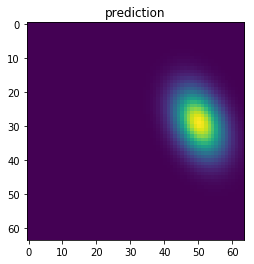

0.9971113980718153


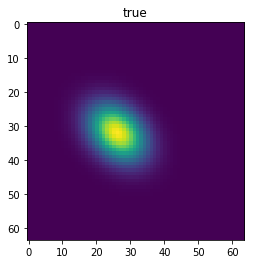

0.9999986216701844


In [14]:
X, Y = np.meshgrid(np.arange(0, 64, 1), np.arange(0, 64, 1)) # X座標,Y座標


img = np.reshape(gaussian(np.c_[X.ravel(),Y.ravel()], np.array([[24,10],[10,42]]), [50,29]),[64,64])
# img = np.ones([64,64])/4096
plt.imshow(img)
plt.title("prediction")
plt.show()
print(np.sum(img))
x = tf.Variable(img[np.newaxis,:,:,np.newaxis]) #予測値


img = np.reshape(gaussian(np.c_[X.ravel(),Y.ravel()], np.array([[32,10],[10,32]]), [26,32]),[64,64])
plt.imshow(img)
plt.title("true")
plt.show()
print(np.sum(img))
y = tf.Variable(img[np.newaxis,:,:,np.newaxis]) #真値

In [32]:
def compKL(p1,p2,smallV=1e-10):
    kl = tf.reduce_sum(p1*(tf.math.log(p1+smallV) - tf.math.log(p2+smallV)))
    return kl

def compSpatialHist(x,kSize=16,sSize=1,isNormMode='sum',thre=0.05):
    # binarize images
#     x_bin = tf.nn.relu(x - thre)
#     x_bin = tf.math.sign(x_bin)

    # kernel with all ones
    kernel = np.ones([kSize,kSize,1,1])
    kernel = tf.constant(kernel, dtype=tf.float64)

    # histogram using conv2d
    x_conv = tf.nn.conv2d(x,kernel,strides=[1,sSize,sSize,1],padding='VALID')
    shape = tf.shape(x_conv)
    x_conv_flat = tf.reshape(x_conv,[shape[0],shape[1]*shape[2]])

    if isNormMode == 'max':
        x_conv_flat = x_conv_flat/tf.reduce_max(x_conv_flat,axis=1,keepdims=True)
    elif isNormMode == 'sum':
        x_conv_flat = x_conv_flat/tf.reduce_sum(x_conv_flat,axis=1,keepdims=True)

    x_conv = tf.reshape(x_conv_flat,[shape[0],shape[1],shape[2]])

    return x_conv

hist_x = compSpatialHist(x)
hist_y = compSpatialHist(y)

In [33]:
kl_loss = compKL(hist_x,hist_y)
grad = tf.gradients(kl_loss,x)[0]

sess.run(tf.global_variables_initializer())

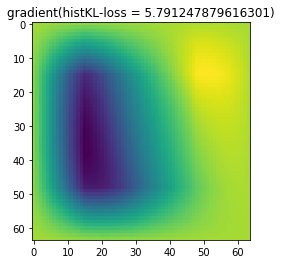

[[-7.89319147e-02 -1.59097106e-01 -2.40365329e-01 ...  1.03772384e-01
   6.85540233e-02  3.38623311e-02]
 [-1.60174762e-01 -3.22853227e-01 -4.87773577e-01 ...  2.12595139e-01
   1.40748163e-01  6.96298319e-02]
 [-2.43580756e-01 -4.90972685e-01 -7.41781147e-01 ...  3.25356532e-01
   2.16019494e-01  1.07085332e-01]
 ...
 [-1.85513687e-01 -3.79406478e-01 -5.81224629e-01 ...  3.31113072e-03
   1.06849066e-02  9.65321268e-03]
 [-1.20391136e-01 -2.46410408e-01 -3.77756656e-01 ...  4.67811502e-04
   5.93737431e-03  5.82896802e-03]
 [-5.85028882e-02 -1.19839979e-01 -1.83861843e-01 ... -6.06746440e-04
   2.39469664e-03  2.62038454e-03]]


In [34]:
grad_value, kl_value = sess.run([grad,kl_loss])
plt.imshow(grad_value[0,:,:,0])
plt.title("gradient(histKL-loss = {})".format(kl_value))
plt.show()

print(grad_value[0,:,:,0])